# Replicating HAM10k

In [ ]:
!nvidia-smi

Mon May 29 19:44:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [03:49<00:00, 25.5MB/s]
100% 5.20G/5.20G [03:49<00:00, 24.3MB/s]


In [ ]:
!unzip -q skin-cancer-mnist-ham10000.zip

In [ ]:
# Load the Drive helper and mount:
from google.colab import drive

# This will prompt for authorization:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.metrics import (f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_curve, auc)
from tqdm.auto import tqdm

import glob

import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

In [ ]:
# Reading the data
path = '.'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [ ]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi', # benign
    'mel': 'Melanoma', # malignant
    'bkl': 'Benign keratosis-like lesions', # benign
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [ ]:
# Image Reading and Resizing.
IMAGE_SIZE = 299
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

  0%|          | 0/10015 [00:00<?, ?it/s]

In [ ]:
X = np.array(train_img,np.float32)
print(X.shape)

(10015, 299, 299, 3)


In [ ]:
y = np.array(skin_df['cell_type_idx'])
print(y.shape)

(10015,)


In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10,
                                                    random_state=28, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10,
                                                  random_state=28, stratify=y_train)

In [ ]:
# One-Hot Encoding values
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val , num_classes=7)

In [ ]:
# Defining base model using Xception module from Keras
training_shape = (299, 299, 3)
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_shape=training_shape)

for layer in base_model.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
n_classes = 7

i = base_model.input
input = inception_preprocess(i)
input = RandomFlip(mode="vertical")(input)
input = RandomRotation(1)(input)

core = base_model(input)

# AdaptiveAvgPool2d in DDI paper
model = GlobalAveragePooling2D()(core)

model = Dropout(0.5)(model)

output = Dense(n_classes, activation='softmax')(model)

model = Model(inputs=i, outputs=output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                             

In [ ]:
# Compiling the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
save_dir = '/content/drive/My Drive/Winter 2023/DDI/Baseline/'
best_model_path = os.path.join(save_dir, "HAM10k_no_DDI.h5")

earlystop = EarlyStopping(monitor = 'val_loss',
                        mode = "min",
                        min_delta = 0,
                        patience = 50,
                        verbose = 1,
                        restore_best_weights=True)

best_model = ModelCheckpoint(best_model_path,
                             monitor = 'val_loss',
                             mode = 'min',
                             verbose = 1,
                             save_best_only = True)

tensor_board = TensorBoard(log_dir = os.path.join(save_dir, 'logs/'),
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)

calls = [earlystop, best_model, tensor_board]

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    callbacks=calls,
                    validation_data=(x_val,y_val))

Epoch 1/500


254/254 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.7387
Epoch 1: val_loss improved from inf to 0.67825, saving model to /content/drive/My Drive/Winter 2023/DDI/Baseline/HAM10k_no_DDI.h5
254/254 [==============================] - 180s 532ms/step - loss: 0.7458 - accuracy: 0.7387 - val_loss: 0.6782 - val_accuracy: 0.7960
Epoch 2/500
254/254 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.8153
Epoch 2: val_loss did not improve from 0.67825
254/254 [==============================] - 125s 491ms/step - loss: 0.5210 - accuracy: 0.8153 - val_loss: 0.8066 - val_accuracy: 0.7129
Epoch 3/500
254/254 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.8428
Epoch 3: val_loss improved from 0.67825 to 0.50754, saving model to /content/drive/My Drive/Winter 2023/DDI/Baseline/HAM10k_no_DDI.h5
254/254 [==============================] - 130s 511ms/step - loss: 0.4269 - accuracy: 0.8428 - val_loss: 0.5075 - val_accuracy: 0.8171
Epoch

Find 5, 10, 15, 20% - train on each, report accs

In [ ]:
def prepare_data(split, image_dir, df, size=(256,256), batches=30):

    # Create an ImageDataGenerator for the images
    datagen = ImageDataGenerator()

    # Generate the training data

    if split == 'test':
        # Generate the testing data
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='DDI_file',
            y_col='malignant',
            class_mode='binary',
            target_size=size,
            batch_size=batches,
            shuffle=False
        )

        light = []
        med = []
        dark = []
        ctr = 0

        for i, row in df.iterrows():
            fn = str(row['DDI_file'])
            tone = int(row['skin_tone'])
            if fn in os.listdir(image_dir):
                if tone == 12:
                    light.append(ctr)
                elif tone == 34:
                    med.append(ctr)
                else:
                    dark.append(ctr)
                ctr += 1

        return generator, light, med, dark

    else:
        # Train/Val data
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='DDI_file',
            y_col='malignant',
            class_mode='binary',
            target_size=size,
            batch_size=batches
        )

        return generator

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

### Retraining on DDI


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                           

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Best threshold: 0.50
0.0


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                           

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Epoch 1/500


1/1 [==============================] - ETA: 0s - loss: 0.7614 - binary_accuracy: 0.4667
Epoch 1: val_binary_accuracy improved from -inf to 0.36667, saving model to /content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/Resized/Fold 3/5%/final_model.h5
1/1 [==============================] - 41s 41s/step - loss: 0.7614 - binary_accuracy: 0.4667 - val_loss: 0.7650 - val_binary_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.7380 - binary_accuracy: 0.5000
Epoch 2: val_binary_accuracy did not improve from 0.36667
1/1 [==============================] - 1s 996ms/step - loss: 0.7380 - binary_accuracy: 0.5000 - val_loss: 0.7665 - val_binary_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 0.6865 - binary_accuracy: 0.5667
Epoch 3: val_binary_accuracy did not improve from 0.36667
1/1 [==============================] - 1s 930ms/step - loss: 0.6865 - binary_accuracy: 

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                           

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 596 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Epoch 1/500


2/2 [==============================] - ETA: 0s - loss: 0.6945 - binary_accuracy: 0.5000 
Epoch 1: val_binary_accuracy improved from -inf to 0.46667, saving model to /content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/Resized/Fold 3/10%/final_model.h5
2/2 [==============================] - 53s 10s/step - loss: 0.6945 - binary_accuracy: 0.5000 - val_loss: 0.6941 - val_binary_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 0.6665 - binary_accuracy: 0.6000
Epoch 2: val_binary_accuracy improved from 0.46667 to 0.53333, saving model to /content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/Resized/Fold 3/10%/final_model.h5
2/2 [==============================] - 4s 3s/step - loss: 0.6665 - binary_accuracy: 0.6000 - val_loss: 0.6896 - val_binary_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 0.6553 - binary_accuracy: 0.6667
Epoch 3: v

1/1 [==============================] - 1s 1s/step
Best threshold: 0.65
0.3


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                          

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 566 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Epoch 1/500


3/3 [==============================] - ETA: 0s - loss: 0.7770 - binary_accuracy: 0.5000
Epoch 1: val_binary_accuracy improved from -inf to 0.43333, saving model to /content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/Resized/Fold 3/15%/final_model.h5
3/3 [==============================] - 49s 5s/step - loss: 0.7770 - binary_accuracy: 0.5000 - val_loss: 0.7968 - val_binary_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 0.7268 - binary_accuracy: 0.5222
Epoch 2: val_binary_accuracy did not improve from 0.43333
3/3 [==============================] - 2s 632ms/step - loss: 0.7268 - binary_accuracy: 0.5222 - val_loss: 0.7956 - val_binary_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 0.7020 - binary_accuracy: 0.5556
Epoch 3: val_binary_accuracy did not improve from 0.43333
3/3 [==============================] - 2s 630ms/step - loss: 0.7020 - binary_accuracy: 

1/1 [==============================] - 1s 1s/step
Best threshold: 0.64
0.5217391304347827


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 random_flip_1 (RandomFlip)  (None, 299, 299, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 299, 299, 3)      0         
 tation)                                                         
                                                          

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 536 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


Found 30 validated image filenames belonging to 2 classes.
Epoch 1/500


4/4 [==============================] - ETA: 0s - loss: 0.7013 - binary_accuracy: 0.4500
Epoch 1: val_binary_accuracy improved from -inf to 0.46667, saving model to /content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/Resized/Fold 3/20%/final_model.h5
4/4 [==============================] - 58s 5s/step - loss: 0.7013 - binary_accuracy: 0.4500 - val_loss: 0.7277 - val_binary_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 2/500
4/4 [==============================] - ETA: 0s - loss: 0.6893 - binary_accuracy: 0.5000
Epoch 2: val_binary_accuracy did not improve from 0.46667
4/4 [==============================] - 2s 587ms/step - loss: 0.6893 - binary_accuracy: 0.5000 - val_loss: 0.7240 - val_binary_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/500
4/4 [==============================] - ETA: 0s - loss: 0.6750 - binary_accuracy: 0.6250
Epoch 3: val_binary_accuracy did not improve from 0.46667
4/4 [==============================] - 2s 578ms/step - loss: 0.6750 - binary_accuracy: 

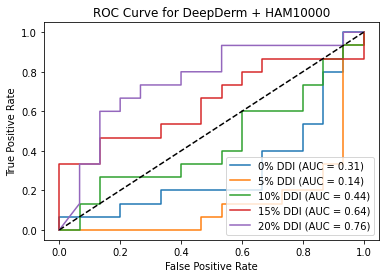

In [ ]:
fracs = [0, 5, 10, 15, 20]
fold = 3
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Classification/{zoom}"

exp_table_path = os.path.join("/content/drive/MyDrive/Winter 2023/DDPM/",
                              "experiments_baseline.csv")

try:
    experiment_table = pd.read_csv(exp_table_path)

except:
    headers = {"Method":[], "DDI Fraction (%)":[], "Train Accuracy (%)":[],
               "Val Accuracy (%)":[], "Test Accuracy (%)":[],
               "Best Threshold":[], "ROC-AUC":[], "F1":[], "Results":[]}

    table = pd.DataFrame.from_dict(headers)
    table.to_csv(exp_table_path, index=False)
    experiment_table = pd.read_csv(exp_table_path)

for frac in fracs:

    if frac != 0:
        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "training_path": f"{base}/Fold {fold}/{frac}%/train",
            "validation_path": f"{base}/Fold {fold}/{frac}%/val",
            "testing_path": f"{base}/Fold {fold}/{frac}%/test",
        }
    else:
        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "training_path": f"{base}/Fold {fold}/{5}%/train",
            "validation_path": f"{base}/Fold {fold}/{5}%/val",
            "testing_path": f"{base}/Fold {fold}/{5}%/test",
        }

    df = pd.read_csv(opts['metadata_path'])
    df['malignant'] = df['malignant'].astype(str)

    encoder = keras.models.load_model("/content/drive/My Drive/Winter 2023/DDI/Baseline/HAM10k_no_DDI.h5")

    output = Dense(1, activation='sigmoid', name='DDI_output')(encoder.output)

    model = Model(inputs=encoder.input, outputs=output)
    model.summary()

    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001),
                      metrics=["binary_accuracy"])

    train_generator = prepare_data('train', opts['training_path'], df, size=(299,299))
    val_generator = prepare_data('val', opts['validation_path'], df, size=(299,299))
    test_generator = prepare_data('test', opts['testing_path'], df, size=(299,299))

    save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/{zoom}/Fold {fold}/{frac}%/"
    best_model_path = os.path.join(save_path, "final_model.h5")

    earlystop = EarlyStopping(monitor = 'val_binary_accuracy',
                    mode = "max",
                    min_delta = 0,
                    patience = 50,
                    verbose = 1,
                    restore_best_weights = True)

    reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy',
                                mode = "max",
                                factor = 0.1,
                                patience = 25,
                                min_lr = 0.00001,
                                verbose = 1)

    best_model = ModelCheckpoint(best_model_path,
                                monitor = 'val_binary_accuracy',
                                mode = 'max',
                                verbose = 1,
                                save_best_only = True)

    tensor_board = TensorBoard(log_dir = os.path.join(save_path, 'logs/'),
                                histogram_freq = 0,
                                write_graph = True,
                                write_images = False)

    callback_list = [reduce_lr, earlystop, best_model, tensor_board]

    if frac != 0:
        history = model.fit(train_generator,
                            epochs=500,
                            verbose=1,
                            validation_data=val_generator,
                            callbacks = callback_list)

    test_loss, test_acc = model.evaluate(test_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    train_loss, train_acc = model.evaluate(train_generator)

    y_pred_prob = model.predict(test_generator)
    y_true = test_generator.classes

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)

    plt.plot(fpr, tpr, label=f'{frac}%% DDI (AUC = %0.2f)' % auc)

    best_threshold = 0
    best_diff = 0
    for j in range(len(thresholds)):
        diff = tpr[j] - fpr[j]
        if diff > best_diff:
            best_diff = diff
            best_threshold = thresholds[j]
    print('Best threshold: %0.2f' % best_threshold)

    y_pred_bin = [int(p > best_threshold) for p in y_pred_prob]

    f1 = f1_score(y_true, y_pred_bin)
    print(f1)

    experiment_table.loc[len(experiment_table)] = ["DeepDerm_HAM10k",
                                                   frac, train_acc, val_acc,
                                                   test_acc, best_threshold,
                                                   auc, f1, save_path]

    experiment_table.to_csv(exp_table_path, index=False)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = f'ROC Curve for DeepDerm + HAM10000'
plt.title(title)
plt.legend(loc='lower right')
plt.savefig(save_path + title + ".pdf")
plt.show()

## Metrics

In [ ]:
def skin_acc(preds, trues):
    goods = 0
    for pred, gt in zip(preds, trues):
        if gt == 1:
            if pred > 0.5:
                goods += 1
        else:
            if pred <= 0.5:
                goods += 1
    return goods / len(preds)

In [ ]:
def get_elements(a, b):
    return [a[i] for i in b]

Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


1/1 [==============================] - 10s 10s/step
Best threshold: 0.00
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Best threshold: 0.65
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Best threshold: 0.64
Found 30 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Best threshold: 0.59


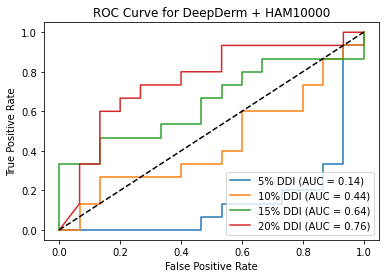

In [ ]:
fracs = [5, 10, 15, 20]
fold = 3
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Classification/{zoom}"

exp_table_path = os.path.join("/content/drive/MyDrive/Winter 2023/DDPM/",
                              "CLS_Rebuttal.csv")

try:
    experiment_table = pd.read_csv(exp_table_path)

except:
    headers = {"Method":[], "DDI Fraction (%)":[], "Block": [], "Timestep": [],
               "Best Threshold":[], "Overall ROC-AUC":[], "Light ROC-AUC":[],
               "Med ROC-AUC":[], "Dark ROC-AUC":[], "F1":[], "Light F1":[],
               "Med F1":[], "Dark F1":[], "Overall Acc (%)":[],
               "Light Acc (%)":[], "Med Acc (%)":[], "Dark Acc (%)":[]}

    table = pd.DataFrame.from_dict(headers)
    table.to_csv(exp_table_path, index=False)
    experiment_table = pd.read_csv(exp_table_path)

for frac in fracs:

    if frac != 0:
        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "training_path": f"{base}/Fold {fold}/{frac}%/train",
            "validation_path": f"{base}/Fold {fold}/{frac}%/val",
            "testing_path": f"{base}/Fold {fold}/{frac}%/test",
        }
    else:
        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "training_path": f"{base}/Fold {fold}/{5}%/train",
            "validation_path": f"{base}/Fold {fold}/{5}%/val",
            "testing_path": f"{base}/Fold {fold}/{5}%/test",
        }

    df = pd.read_csv(opts['metadata_path'])
    df['malignant'] = df['malignant'].astype(str)

    test_generator = prepare_data('test', opts['testing_path'], df, size=(299,299))

    if frac != 0:
        save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/{zoom}/Fold {fold}/{frac}%/"
        best_model_path = os.path.join(save_path, "final_model.h5")

        model = keras.models.load_model(best_model_path)
    else:
        encoder = keras.models.load_model("/content/drive/My Drive/Winter 2023/DDI/Baseline/HAM10k_no_DDI.h5")

        output = Dense(1, activation='sigmoid', name='DDI_output')(encoder.output)

        model = Model(inputs=encoder.input, outputs=output)
        model.summary()

        model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001),
                        metrics=["binary_accuracy"])

    y_pred_prob = model.predict(test_generator)
    y_true = test_generator.classes

    test_acc = skin_acc(y_pred_prob.flatten(), y_true)

    dark_idx = [0, 1, 2, 3, 5, 6, 7, 8, 10, 11]
    med_idx = [9, 18, 20, 23, 24, 25, 26, 27, 28, 29]
    light_idx = [4, 12, 13, 14, 15, 16, 17, 19, 21, 22]

    dark_trues = get_elements(y_true, dark_idx)
    dark_preds = get_elements(y_pred_prob.flatten(), dark_idx)
    dark_acc = skin_acc(dark_preds, dark_trues)

    med_trues = get_elements(y_true, med_idx)
    med_preds = get_elements(y_pred_prob.flatten(), med_idx)
    med_acc = skin_acc(med_preds, med_trues)

    light_trues = get_elements(y_true, light_idx)
    light_preds = get_elements(y_pred_prob.flatten(), light_idx)
    light_acc = skin_acc(light_preds, light_trues)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    auc = roc_auc_score(y_true, y_pred_prob)
    light_auc = roc_auc_score(light_trues, light_preds)
    med_auc = roc_auc_score(med_trues, med_preds)
    dark_auc = roc_auc_score(dark_trues, dark_preds)

    plt.plot(fpr, tpr, label=f'{frac}%% DDI (AUC = %0.2f)' % auc)

    best_threshold = 0
    best_diff = 0
    for j in range(len(thresholds)):
        diff = tpr[j] - fpr[j]
        if diff > best_diff:
            best_diff = diff
            best_threshold = thresholds[j]
    print('Best threshold: %0.2f' % best_threshold)

    y_pred_bin = [int(p > best_threshold) for p in y_pred_prob]
    f1 = f1_score(y_true, y_pred_bin)

    y_pred_bin_light = [int(p > best_threshold) for p in light_preds]
    light_f1 = f1_score(light_trues, y_pred_bin_light)

    y_pred_bin_med = [int(p > best_threshold) for p in med_preds]
    med_f1 = f1_score(med_trues, y_pred_bin_med)

    y_pred_bin_dark = [int(p > best_threshold) for p in dark_preds]
    dark_f1 = f1_score(dark_trues, y_pred_bin_dark)


    experiment_table.loc[len(experiment_table)] = ["DeepDerm_HAM10k", frac,
                                                    "N/A", "N/A", best_threshold, auc,
                                                    light_auc, med_auc, dark_auc,
                                                    f1, light_f1, med_f1, dark_f1,
                                                    test_acc, light_acc,
                                                    med_acc, dark_acc]

    experiment_table.to_csv(exp_table_path, index=False)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = f'ROC Curve for DeepDerm + HAM10000'
plt.title(title)
plt.legend(loc='lower right')
plt.savefig(save_path + title + ".pdf")
plt.show()

In [ ]:
base = f"/content/drive/MyDrive/Winter 2023/DDI/Classification/Resized/Fold 3/20%/"
train = os.listdir(base + "train")
val = os.listdir(base + "val")
all = os.listdir("/content/drive/MyDrive/Winter 2023/DDI/DDI_Full/")

test = list(set(all) - set(train + val))

In [ ]:
len(test)

506

In [ ]:
import shutil

In [ ]:
def copy_file(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(src, dst)

In [ ]:
for fn in test:
    copy_file("/content/drive/MyDrive/Winter 2023/DDI/DDI_Full/" + fn,
              f"/content/drive/MyDrive/Winter 2023/DDI/Segmentation Labels/Resized/Rebuttal/Fold 3/cls_test/")

Found 506 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 150 invalid image filename(s) in x_col="DDI_file". These filename(s) will be ignored.
  warnings.warn(


NameError: ignored

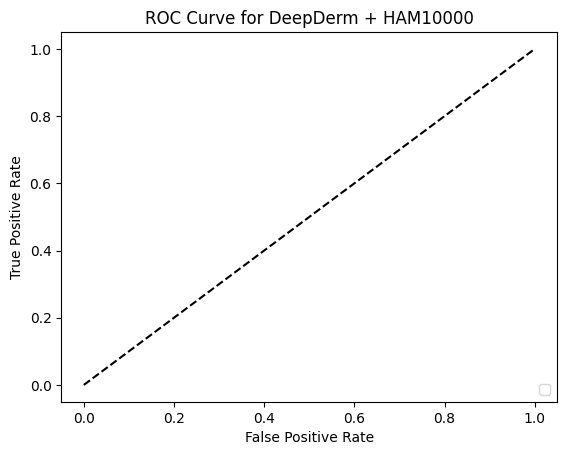

In [ ]:
fracs = [5, 10, 15, 20]
fold = 3
zoom = "Resized"
base = f"/content/drive/MyDrive/Winter 2023/DDI/Segmentation Labels/{zoom}/Rebuttal"

exp_table_path = os.path.join("/content/drive/MyDrive/Winter 2023/DDPM/",
                              "CLS_Rebuttal.csv")

try:
    experiment_table = pd.read_csv(exp_table_path)

except:
    headers = {"Method":[], "DDI Fraction (%)":[], "Block": [], "Timestep": [],
               "Best Threshold":[], "Overall ROC-AUC":[], "Light ROC-AUC":[],
               "Med ROC-AUC":[], "Dark ROC-AUC":[], "F1":[], "Light F1":[],
               "Med F1":[], "Dark F1":[], "Overall Acc (%)":[],
               "Light Acc (%)":[], "Med Acc (%)":[], "Dark Acc (%)":[]}

    table = pd.DataFrame.from_dict(headers)
    table.to_csv(exp_table_path, index=False)
    experiment_table = pd.read_csv(exp_table_path)

for frac in fracs:

    if frac != 0:
        opts = {
            "metadata_path": '/content/drive/MyDrive/Winter 2023/DDI/ddi_metadata.csv',
            "testing_path": f"{base}/Fold {fold}/cls_test", # contains all images not in train/val of 20%
        }

    df = pd.read_csv(opts['metadata_path'])
    df['malignant'] = df['malignant'].astype(str)

    test_generator, light_idx, med_idx, dark_idx = prepare_data('test', opts['testing_path'], df, size=(299,299))
    break

    if frac != 0:
        save_path = f"/content/drive/MyDrive/Winter 2023/DDPM/pixel_classifiers/cnn_v2/DeepDerm_HAM10k/{zoom}/Fold {fold}/{frac}%/"
        best_model_path = os.path.join(save_path, "final_model.h5")

        model = keras.models.load_model(best_model_path)

    y_pred_prob = model.predict(test_generator)
    y_true = test_generator.classes

    test_acc = skin_acc(y_pred_prob.flatten(), y_true)

    dark_trues = get_elements(y_true, dark_idx)
    dark_preds = get_elements(y_pred_prob.flatten(), dark_idx)
    dark_acc = skin_acc(dark_preds, dark_trues)

    med_trues = get_elements(y_true, med_idx)
    med_preds = get_elements(y_pred_prob.flatten(), med_idx)
    med_acc = skin_acc(med_preds, med_trues)

    light_trues = get_elements(y_true, light_idx)
    light_preds = get_elements(y_pred_prob.flatten(), light_idx)
    light_acc = skin_acc(light_preds, light_trues)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    auc = roc_auc_score(y_true, y_pred_prob)
    light_auc = roc_auc_score(light_trues, light_preds)
    med_auc = roc_auc_score(med_trues, med_preds)
    dark_auc = roc_auc_score(dark_trues, dark_preds)

    plt.plot(fpr, tpr, label=f'{frac}%% DDI (AUC = %0.2f)' % auc)

    best_threshold = 0
    best_diff = 0
    for j in range(len(thresholds)):
        diff = tpr[j] - fpr[j]
        if diff > best_diff:
            best_diff = diff
            best_threshold = thresholds[j]
    print('Best threshold: %0.2f' % best_threshold)

    y_pred_bin = [int(p > best_threshold) for p in y_pred_prob]
    f1 = f1_score(y_true, y_pred_bin)

    y_pred_bin_light = [int(p > best_threshold) for p in light_preds]
    light_f1 = f1_score(light_trues, y_pred_bin_light)

    y_pred_bin_med = [int(p > best_threshold) for p in med_preds]
    med_f1 = f1_score(med_trues, y_pred_bin_med)

    y_pred_bin_dark = [int(p > best_threshold) for p in dark_preds]
    dark_f1 = f1_score(dark_trues, y_pred_bin_dark)


    experiment_table.loc[len(experiment_table)] = ["DeepDerm_HAM10k", frac,
                                                    "N/A", "N/A", best_threshold, auc,
                                                    light_auc, med_auc, dark_auc,
                                                    f1, light_f1, med_f1, dark_f1,
                                                    test_acc, light_acc,
                                                    med_acc, dark_acc]

    experiment_table.to_csv(exp_table_path, index=False)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = f'ROC Curve for DeepDerm + HAM10000'
plt.title(title)
plt.legend(loc='lower right')
plt.savefig(save_path + title + ".pdf")
plt.show()

In [ ]:
len(light_idx)

158

In [ ]:
len(med_idx)

191

In [ ]:
len(dark_idx)

157

In [ ]:
print(light_idx)

[3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 41, 42, 82, 83, 182, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332]


In [ ]:
print(med_idx)

[5, 15, 30, 35, 40, 49, 50, 61, 62, 63, 78, 136, 162, 163, 181, 273, 274, 297, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505]


In [ ]:
print(dark_idx)

[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 186, 187]
